# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4850504110632556 -2.782703893048929
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    return states, actions, targetQs, cell, g_initial_state, d_initial_state

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# MLP & Conv
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [17]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [18]:
# MLP & Conv
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [19]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [21]:
def model_loss(action_size, hidden_size, states, actions, targetQs,
               cell, g_initial_state, d_initial_state):
    # G/Actor
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D/Critic
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    d_loss = tf.reduce_mean(tf.square(tf.reshape(Qs_logits, [-1]) - targetQs))

    return actions_logits, Qs_logits, g_final_state, d_final_state, g_loss, d_loss

In [22]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [23]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_final_state, self.d_final_state, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell, targetQs=self.targetQs,
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [24]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [25]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [26]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 64                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [27]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


In [28]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [29]:
memory.buffer[0]

[array([ 0.01488493,  0.0249929 , -0.01551666, -0.01318757]),
 0,
 array([ 0.01538478, -0.16990313, -0.01578041,  0.27455956]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list, rates_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits, g_final_state, d_final_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state,
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([g_initial_state, g_final_state,
                                  d_initial_state, d_final_state])
            total_reward += reward
            g_initial_state = g_final_state
            d_initial_state = d_final_state
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            g_initial_states = np.array([each[0] for each in rnn_states])
            g_final_states = np.array([each[1] for each in rnn_states])
            d_initial_states = np.array([each[2] for each in rnn_states])
            d_final_states = np.array([each[3] for each in rnn_states])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states, 
                                                  model.g_initial_state: g_final_states[0].reshape([1, -1]),
                                                  model.d_initial_state: d_final_states[0].reshape([1, -1])})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            g_loss, d_loss, _, _ = sess.run(fetches=[model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs,
                                    model.g_initial_state: g_initial_states[0].reshape([1, -1]),
                                    model.d_initial_state: d_initial_states[0].reshape([1, -1])})
            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episode_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-seq.ckpt')

Episode:0 meanR:28.0000 rate:0.0560 gloss:1.0571 dloss:1.0060
Episode:1 meanR:27.5000 rate:0.0540 gloss:1.3877 dloss:1.0198
Episode:2 meanR:28.0000 rate:0.0580 gloss:1.0106 dloss:1.0734
Episode:3 meanR:27.0000 rate:0.0480 gloss:0.5829 dloss:1.6101
Episode:4 meanR:26.0000 rate:0.0440 gloss:0.0538 dloss:2.9626
Episode:5 meanR:27.5000 rate:0.0700 gloss:0.3021 dloss:4.3547
Episode:6 meanR:28.2857 rate:0.0660 gloss:0.1991 dloss:5.9709
Episode:7 meanR:28.0000 rate:0.0520 gloss:0.0363 dloss:10.8918
Episode:8 meanR:28.2222 rate:0.0600 gloss:0.0010 dloss:13.0890
Episode:9 meanR:31.7000 rate:0.1260 gloss:0.0005 dloss:11.4073
Episode:10 meanR:32.5455 rate:0.0820 gloss:0.0003 dloss:8.9842
Episode:11 meanR:31.6667 rate:0.0440 gloss:0.0003 dloss:9.4290
Episode:12 meanR:36.4615 rate:0.1880 gloss:0.2530 dloss:10.0551
Episode:13 meanR:36.0714 rate:0.0620 gloss:0.2533 dloss:16.8407
Episode:14 meanR:37.4667 rate:0.1140 gloss:0.0040 dloss:2.8757
Episode:15 meanR:36.7500 rate:0.0520 gloss:0.0019 dloss:3.24

Episode:130 meanR:40.9200 rate:0.0620 gloss:0.0091 dloss:0.8204
Episode:131 meanR:41.1400 rate:0.1000 gloss:0.0099 dloss:0.6269
Episode:132 meanR:40.9400 rate:0.0520 gloss:0.0012 dloss:0.8940
Episode:133 meanR:40.3200 rate:0.0780 gloss:0.0005 dloss:0.8108
Episode:134 meanR:40.6200 rate:0.1160 gloss:0.0081 dloss:0.9785
Episode:135 meanR:40.7600 rate:0.0840 gloss:0.0010 dloss:0.9324
Episode:136 meanR:40.8300 rate:0.0920 gloss:0.0501 dloss:0.9836
Episode:137 meanR:40.8300 rate:0.0600 gloss:0.0183 dloss:1.8774
Episode:138 meanR:40.9700 rate:0.0800 gloss:0.0033 dloss:0.8378
Episode:139 meanR:41.0400 rate:0.0680 gloss:0.0015 dloss:0.4781
Episode:140 meanR:41.0000 rate:0.0560 gloss:0.0012 dloss:0.4053
Episode:141 meanR:40.8500 rate:0.0620 gloss:0.0109 dloss:0.6008
Episode:142 meanR:41.2200 rate:0.1200 gloss:0.0003 dloss:2.4812
Episode:143 meanR:41.0700 rate:0.0760 gloss:0.0048 dloss:1.7018
Episode:144 meanR:41.0500 rate:0.0680 gloss:0.0003 dloss:1.1041
Episode:145 meanR:41.2600 rate:0.1060 gl

Episode:258 meanR:41.9600 rate:0.1200 gloss:0.0078 dloss:1.0469
Episode:259 meanR:41.8700 rate:0.0600 gloss:0.0018 dloss:1.1928
Episode:260 meanR:41.8400 rate:0.0500 gloss:0.0011 dloss:1.3578
Episode:261 meanR:41.3700 rate:0.0580 gloss:0.0001 dloss:0.6214
Episode:262 meanR:41.4800 rate:0.1020 gloss:0.0008 dloss:1.0081
Episode:263 meanR:41.4500 rate:0.0500 gloss:0.0006 dloss:0.8442
Episode:264 meanR:41.5200 rate:0.0680 gloss:0.0000 dloss:0.6477
Episode:265 meanR:41.3200 rate:0.0640 gloss:0.0000 dloss:0.3769
Episode:266 meanR:41.4900 rate:0.0860 gloss:0.0000 dloss:0.3605
Episode:267 meanR:41.4300 rate:0.0560 gloss:0.0000 dloss:0.7161
Episode:268 meanR:41.6900 rate:0.1080 gloss:0.0000 dloss:0.7434
Episode:269 meanR:41.3700 rate:0.0540 gloss:0.0001 dloss:0.7013
Episode:270 meanR:41.3600 rate:0.1180 gloss:0.0160 dloss:2.3043
Episode:271 meanR:41.1200 rate:0.1060 gloss:0.0149 dloss:1.5394
Episode:272 meanR:41.4100 rate:0.1620 gloss:0.0000 dloss:0.8407
Episode:273 meanR:41.2900 rate:0.0600 gl

Episode:387 meanR:38.3900 rate:0.1040 gloss:0.0018 dloss:2.0349
Episode:388 meanR:38.2000 rate:0.0540 gloss:0.0000 dloss:1.3146
Episode:389 meanR:38.0800 rate:0.0500 gloss:0.0000 dloss:2.5549
Episode:390 meanR:38.2900 rate:0.1300 gloss:0.0035 dloss:1.9147
Episode:391 meanR:38.2100 rate:0.0820 gloss:0.0001 dloss:1.4466
Episode:392 meanR:38.1300 rate:0.0500 gloss:0.0010 dloss:2.4198
Episode:393 meanR:38.1200 rate:0.0460 gloss:0.0000 dloss:2.3614
Episode:394 meanR:38.2100 rate:0.0720 gloss:0.0002 dloss:1.9669
Episode:395 meanR:38.0800 rate:0.0680 gloss:0.0013 dloss:1.6245
Episode:396 meanR:37.8200 rate:0.0560 gloss:0.0002 dloss:1.7318
Episode:397 meanR:37.9100 rate:0.0700 gloss:0.0024 dloss:1.6916
Episode:398 meanR:37.7700 rate:0.0700 gloss:0.0000 dloss:0.6387
Episode:399 meanR:37.5800 rate:0.0460 gloss:0.0002 dloss:0.9150
Episode:400 meanR:37.6100 rate:0.0620 gloss:0.0015 dloss:0.9453
Episode:401 meanR:37.5500 rate:0.0740 gloss:0.0001 dloss:0.5361
Episode:402 meanR:37.7600 rate:0.0900 gl

Episode:516 meanR:33.9600 rate:0.0740 gloss:0.0002 dloss:3.1228
Episode:517 meanR:33.7800 rate:0.0460 gloss:0.0003 dloss:1.0663
Episode:518 meanR:33.8400 rate:0.0860 gloss:0.0000 dloss:0.7937
Episode:519 meanR:33.8900 rate:0.0660 gloss:0.0000 dloss:0.5107
Episode:520 meanR:33.7200 rate:0.0500 gloss:0.0000 dloss:0.5250
Episode:521 meanR:33.7700 rate:0.0680 gloss:0.0000 dloss:0.4457
Episode:522 meanR:33.4800 rate:0.0640 gloss:0.0000 dloss:0.3615
Episode:523 meanR:33.5300 rate:0.0660 gloss:0.0000 dloss:0.5076
Episode:524 meanR:33.4900 rate:0.0460 gloss:0.0000 dloss:0.3032
Episode:525 meanR:33.4700 rate:0.0560 gloss:0.0000 dloss:0.2454
Episode:526 meanR:33.7300 rate:0.0980 gloss:0.0000 dloss:0.3969
Episode:527 meanR:33.8000 rate:0.0800 gloss:0.0003 dloss:0.3560
Episode:528 meanR:33.8800 rate:0.0600 gloss:0.0000 dloss:0.5390
Episode:529 meanR:33.7200 rate:0.0520 gloss:0.0000 dloss:0.6593
Episode:530 meanR:33.6500 rate:0.0400 gloss:0.0000 dloss:0.9952
Episode:531 meanR:33.6500 rate:0.0780 gl

Episode:645 meanR:32.5600 rate:0.0520 gloss:0.0014 dloss:0.6450
Episode:646 meanR:32.4400 rate:0.0660 gloss:0.0001 dloss:0.4852
Episode:647 meanR:32.2200 rate:0.0460 gloss:0.0001 dloss:0.4254
Episode:648 meanR:32.1600 rate:0.0500 gloss:0.0005 dloss:0.2544
Episode:649 meanR:32.1900 rate:0.0720 gloss:0.0005 dloss:0.8976
Episode:650 meanR:32.0500 rate:0.0460 gloss:0.0007 dloss:0.6616
Episode:651 meanR:31.9800 rate:0.0700 gloss:0.0001 dloss:0.3759
Episode:652 meanR:32.1100 rate:0.0720 gloss:0.0173 dloss:0.6906
Episode:653 meanR:32.1000 rate:0.0740 gloss:0.9334 dloss:2.3849
Episode:654 meanR:32.3800 rate:0.1320 gloss:0.0185 dloss:2.5881
Episode:655 meanR:32.1800 rate:0.0460 gloss:0.0103 dloss:1.5131
Episode:656 meanR:32.2100 rate:0.0600 gloss:0.0005 dloss:0.7259
Episode:657 meanR:32.6400 rate:0.1340 gloss:0.0046 dloss:0.9218
Episode:658 meanR:32.6600 rate:0.0500 gloss:0.0013 dloss:0.8202
Episode:659 meanR:32.6600 rate:0.0500 gloss:0.0009 dloss:0.8005
Episode:660 meanR:32.6200 rate:0.0540 gl

Episode:774 meanR:36.4200 rate:0.0460 gloss:0.0011 dloss:0.9245
Episode:775 meanR:36.1200 rate:0.0520 gloss:0.0002 dloss:0.2981
Episode:776 meanR:36.3300 rate:0.0940 gloss:0.0001 dloss:0.3825
Episode:777 meanR:36.0300 rate:0.0460 gloss:0.0000 dloss:0.8128
Episode:778 meanR:35.7100 rate:0.0460 gloss:0.0010 dloss:0.4681
Episode:779 meanR:35.5200 rate:0.0680 gloss:0.0002 dloss:0.4877
Episode:780 meanR:35.4700 rate:0.0560 gloss:0.0000 dloss:0.7052
Episode:781 meanR:35.4100 rate:0.0820 gloss:0.0000 dloss:0.4712
Episode:782 meanR:35.2900 rate:0.0720 gloss:0.0002 dloss:0.2013
Episode:783 meanR:35.2400 rate:0.0460 gloss:0.0001 dloss:0.3421
Episode:784 meanR:35.3500 rate:0.1000 gloss:0.0005 dloss:0.3069
Episode:785 meanR:35.2000 rate:0.0760 gloss:0.0000 dloss:0.3005
Episode:786 meanR:35.2600 rate:0.0620 gloss:0.0000 dloss:0.4124
Episode:787 meanR:35.1700 rate:0.0520 gloss:0.0000 dloss:0.5183
Episode:788 meanR:35.1500 rate:0.0580 gloss:0.0000 dloss:0.2654
Episode:789 meanR:34.9100 rate:0.0420 gl

Episode:902 meanR:35.9100 rate:0.0600 gloss:0.0000 dloss:0.8114
Episode:903 meanR:35.7600 rate:0.0480 gloss:0.0000 dloss:0.7068
Episode:904 meanR:35.9800 rate:0.1100 gloss:0.0005 dloss:0.4074
Episode:905 meanR:36.1100 rate:0.0840 gloss:0.0001 dloss:2.1730
Episode:906 meanR:35.9400 rate:0.0520 gloss:0.0000 dloss:1.5220
Episode:907 meanR:35.8500 rate:0.0440 gloss:0.0000 dloss:0.8596
Episode:908 meanR:35.7900 rate:0.0420 gloss:0.0010 dloss:1.2536
Episode:909 meanR:35.4900 rate:0.0460 gloss:0.0001 dloss:0.9112
Episode:910 meanR:35.5800 rate:0.1180 gloss:0.0001 dloss:2.3320
Episode:911 meanR:35.5400 rate:0.0460 gloss:0.0020 dloss:1.6183
Episode:912 meanR:35.1700 rate:0.0440 gloss:0.0001 dloss:1.8424
Episode:913 meanR:35.1800 rate:0.0560 gloss:0.0001 dloss:1.1905
Episode:914 meanR:35.3900 rate:0.0860 gloss:0.0000 dloss:0.7668
Episode:915 meanR:35.4000 rate:0.0600 gloss:0.0000 dloss:1.4816
Episode:916 meanR:35.5600 rate:0.0720 gloss:0.0000 dloss:1.4914
Episode:917 meanR:35.4300 rate:0.0740 gl

Episode:1030 meanR:35.8100 rate:0.0820 gloss:0.0000 dloss:1.5843
Episode:1031 meanR:35.6400 rate:0.0540 gloss:0.0000 dloss:1.4164
Episode:1032 meanR:35.7500 rate:0.0760 gloss:0.0003 dloss:2.4581
Episode:1033 meanR:36.0100 rate:0.1000 gloss:0.0002 dloss:1.6176
Episode:1034 meanR:35.8100 rate:0.0680 gloss:0.0001 dloss:2.0266
Episode:1035 meanR:35.7800 rate:0.0480 gloss:0.0000 dloss:2.6253
Episode:1036 meanR:35.9400 rate:0.1120 gloss:0.0001 dloss:2.3908
Episode:1037 meanR:35.3600 rate:0.0400 gloss:0.0001 dloss:2.9360
Episode:1038 meanR:35.2900 rate:0.0420 gloss:0.0000 dloss:3.2312
Episode:1039 meanR:35.4600 rate:0.0880 gloss:0.5262 dloss:6.9440
Episode:1040 meanR:35.5400 rate:0.0600 gloss:0.0305 dloss:1.8413
Episode:1041 meanR:35.5600 rate:0.0640 gloss:0.0000 dloss:1.5950
Episode:1042 meanR:35.7100 rate:0.0780 gloss:0.0035 dloss:1.5856
Episode:1043 meanR:35.5000 rate:0.0440 gloss:0.0013 dloss:1.3384
Episode:1044 meanR:35.4300 rate:0.0740 gloss:0.0000 dloss:0.6209
Episode:1045 meanR:35.200

Episode:1157 meanR:37.2400 rate:0.0560 gloss:0.0000 dloss:3.7423
Episode:1158 meanR:37.5800 rate:0.1280 gloss:0.0002 dloss:2.1551
Episode:1159 meanR:37.6700 rate:0.0760 gloss:0.0000 dloss:2.6526
Episode:1160 meanR:37.5400 rate:0.0540 gloss:0.0001 dloss:2.8691
Episode:1161 meanR:37.3700 rate:0.0480 gloss:0.0000 dloss:3.5179
Episode:1162 meanR:37.5900 rate:0.1180 gloss:0.0000 dloss:0.8814
Episode:1163 meanR:37.4600 rate:0.0480 gloss:0.0000 dloss:2.5158
Episode:1164 meanR:37.5100 rate:0.0700 gloss:0.0000 dloss:2.3739
Episode:1165 meanR:37.3700 rate:0.0400 gloss:0.0000 dloss:2.2206
Episode:1166 meanR:37.3500 rate:0.0680 gloss:0.0000 dloss:3.3157
Episode:1167 meanR:37.3100 rate:0.0780 gloss:0.0000 dloss:3.4475
Episode:1168 meanR:37.6400 rate:0.1200 gloss:0.0001 dloss:2.2456
Episode:1169 meanR:37.6000 rate:0.0400 gloss:0.0001 dloss:2.5626
Episode:1170 meanR:37.7800 rate:0.0900 gloss:0.0000 dloss:1.9859
Episode:1171 meanR:37.8300 rate:0.0920 gloss:0.0000 dloss:2.2938
Episode:1172 meanR:38.110

Episode:1284 meanR:44.8400 rate:0.1980 gloss:0.0000 dloss:1.2183
Episode:1285 meanR:44.9000 rate:0.0780 gloss:0.0001 dloss:1.6942
Episode:1286 meanR:44.4600 rate:0.0800 gloss:0.0001 dloss:1.4395
Episode:1287 meanR:45.2600 rate:0.3240 gloss:0.0056 dloss:12.5982
Episode:1288 meanR:46.0900 rate:0.2060 gloss:0.0000 dloss:4.1072
Episode:1289 meanR:45.9400 rate:0.0580 gloss:0.0023 dloss:4.7095
Episode:1290 meanR:46.0700 rate:0.1140 gloss:0.0008 dloss:2.3346
Episode:1291 meanR:46.2600 rate:0.1480 gloss:0.0000 dloss:1.5013
Episode:1292 meanR:46.4600 rate:0.0840 gloss:0.0000 dloss:3.1724
Episode:1293 meanR:47.5700 rate:0.2860 gloss:0.0068 dloss:102.4193
Episode:1294 meanR:47.4500 rate:0.0480 gloss:0.0015 dloss:53.8490
Episode:1295 meanR:47.4000 rate:0.0420 gloss:0.0005 dloss:25.3738
Episode:1296 meanR:47.3400 rate:0.0480 gloss:0.0002 dloss:4.1261
Episode:1297 meanR:47.2400 rate:0.0680 gloss:0.0004 dloss:3.6203
Episode:1298 meanR:47.2900 rate:0.0520 gloss:0.0004 dloss:3.1984
Episode:1299 meanR:4

Episode:1410 meanR:49.1600 rate:0.1220 gloss:0.0004 dloss:1.6628
Episode:1411 meanR:48.9700 rate:0.0560 gloss:0.0013 dloss:4.3517
Episode:1412 meanR:48.9500 rate:0.0480 gloss:0.0014 dloss:2.8590
Episode:1413 meanR:49.1900 rate:0.1140 gloss:0.0004 dloss:1.7837
Episode:1414 meanR:49.0400 rate:0.0460 gloss:0.0036 dloss:3.6207
Episode:1415 meanR:49.1600 rate:0.0720 gloss:0.0009 dloss:3.5698
Episode:1416 meanR:49.1600 rate:0.0740 gloss:0.0003 dloss:2.1754
Episode:1417 meanR:48.5700 rate:0.0800 gloss:0.0003 dloss:2.3004
Episode:1418 meanR:48.2700 rate:0.0560 gloss:0.0003 dloss:1.9537
Episode:1419 meanR:48.5300 rate:0.1000 gloss:0.0003 dloss:2.3070
Episode:1420 meanR:48.3700 rate:0.0480 gloss:0.0003 dloss:2.9364
Episode:1421 meanR:49.2300 rate:0.2220 gloss:0.0081 dloss:2.2301
Episode:1422 meanR:49.1500 rate:0.0500 gloss:0.0035 dloss:5.3289
Episode:1423 meanR:49.1800 rate:0.0660 gloss:0.0031 dloss:5.6314
Episode:1424 meanR:49.2200 rate:0.0540 gloss:0.0043 dloss:4.2024
Episode:1425 meanR:49.240

Episode:1536 meanR:46.0000 rate:0.0760 gloss:0.0831 dloss:8.6895
Episode:1537 meanR:45.8900 rate:0.0520 gloss:0.0028 dloss:7.1216
Episode:1538 meanR:45.6700 rate:0.0580 gloss:0.0010 dloss:11.7053
Episode:1539 meanR:46.4100 rate:0.2340 gloss:0.0019 dloss:16.1275
Episode:1540 meanR:45.2100 rate:0.0500 gloss:0.0004 dloss:18.2132
Episode:1541 meanR:46.8200 rate:0.3680 gloss:0.0001 dloss:15.7326
Episode:1542 meanR:46.8900 rate:0.0820 gloss:0.0003 dloss:13.8701
Episode:1543 meanR:46.5900 rate:0.0460 gloss:0.0800 dloss:10.8194
Episode:1544 meanR:46.5700 rate:0.0440 gloss:0.0002 dloss:7.6990
Episode:1545 meanR:46.5300 rate:0.0480 gloss:0.0003 dloss:4.7223
Episode:1546 meanR:45.5700 rate:0.0800 gloss:0.0005 dloss:3.4180
Episode:1547 meanR:45.5200 rate:0.0480 gloss:0.0089 dloss:3.8612
Episode:1548 meanR:45.9800 rate:0.1940 gloss:0.0208 dloss:18.3590
Episode:1549 meanR:45.6800 rate:0.0840 gloss:0.0014 dloss:21.7244
Episode:1550 meanR:45.6800 rate:0.0520 gloss:0.0003 dloss:7.1573
Episode:1551 mean

Episode:1662 meanR:50.6100 rate:0.2420 gloss:0.0005 dloss:6.6594
Episode:1663 meanR:50.7900 rate:0.1000 gloss:0.0001 dloss:12.8494
Episode:1664 meanR:50.1000 rate:0.0840 gloss:0.0000 dloss:8.8527
Episode:1665 meanR:49.9800 rate:0.0440 gloss:0.0000 dloss:9.7789
Episode:1666 meanR:49.6500 rate:0.1400 gloss:0.0000 dloss:2.1418
Episode:1667 meanR:49.8500 rate:0.2920 gloss:0.0108 dloss:9.7176
Episode:1668 meanR:49.8200 rate:0.0560 gloss:0.0001 dloss:10.6447
Episode:1669 meanR:49.7700 rate:0.0540 gloss:-0.0000 dloss:21.1263
Episode:1670 meanR:49.8900 rate:0.0880 gloss:0.0000 dloss:4.7128
Episode:1671 meanR:49.7900 rate:0.0640 gloss:0.0000 dloss:3.7239
Episode:1672 meanR:49.6300 rate:0.0500 gloss:0.0000 dloss:2.4427
Episode:1673 meanR:49.6400 rate:0.0580 gloss:0.0000 dloss:1.8417
Episode:1674 meanR:48.9000 rate:0.1900 gloss:0.0012 dloss:9.2729
Episode:1675 meanR:49.5200 rate:0.1900 gloss:0.0008 dloss:24.5036
Episode:1676 meanR:49.4300 rate:0.0720 gloss:0.0002 dloss:22.9123
Episode:1677 meanR:

Episode:1788 meanR:45.9900 rate:0.0460 gloss:0.0005 dloss:5.0400
Episode:1789 meanR:45.8100 rate:0.0720 gloss:0.0002 dloss:2.2988
Episode:1790 meanR:45.8600 rate:0.0580 gloss:0.0000 dloss:1.8028
Episode:1791 meanR:45.8200 rate:0.0640 gloss:0.0000 dloss:2.0214
Episode:1792 meanR:45.8900 rate:0.0640 gloss:0.0000 dloss:2.6854
Episode:1793 meanR:45.9700 rate:0.0680 gloss:0.0000 dloss:2.0534
Episode:1794 meanR:46.0000 rate:0.0500 gloss:0.0000 dloss:2.3632
Episode:1795 meanR:46.2300 rate:0.0920 gloss:0.0007 dloss:1.0826
Episode:1796 meanR:46.2700 rate:0.0600 gloss:0.0000 dloss:1.2475
Episode:1797 meanR:47.4800 rate:0.2880 gloss:0.0018 dloss:25.2808
Episode:1798 meanR:47.3100 rate:0.0560 gloss:-0.0001 dloss:23.5684
Episode:1799 meanR:47.8800 rate:0.1740 gloss:0.0004 dloss:17.4498
Episode:1800 meanR:48.1900 rate:0.1500 gloss:0.0006 dloss:2.9913
Episode:1801 meanR:47.4200 rate:0.0520 gloss:0.0002 dloss:9.9987
Episode:1802 meanR:47.6200 rate:0.0880 gloss:0.1014 dloss:17.3741
Episode:1803 meanR:4

Episode:1914 meanR:38.6300 rate:0.0680 gloss:0.0006 dloss:3.9666
Episode:1915 meanR:38.5700 rate:0.0440 gloss:0.0006 dloss:3.6202
Episode:1916 meanR:39.6900 rate:0.2700 gloss:0.0505 dloss:6.7639
Episode:1917 meanR:39.8000 rate:0.1460 gloss:0.0010 dloss:10.4919
Episode:1918 meanR:40.1700 rate:0.1200 gloss:0.0008 dloss:14.5216
Episode:1919 meanR:40.0300 rate:0.0600 gloss:0.0033 dloss:21.7720
Episode:1920 meanR:40.7500 rate:0.2060 gloss:0.0070 dloss:15.1996
Episode:1921 meanR:41.1600 rate:0.1280 gloss:0.0014 dloss:25.3125
Episode:1922 meanR:41.5900 rate:0.1320 gloss:0.0013 dloss:4.8987
Episode:1923 meanR:42.3400 rate:0.1980 gloss:0.0159 dloss:16.0154
Episode:1924 meanR:42.7000 rate:0.2020 gloss:0.0027 dloss:16.8085
Episode:1925 meanR:42.7000 rate:0.0480 gloss:0.0016 dloss:23.4013
Episode:1926 meanR:42.6700 rate:0.0520 gloss:0.0024 dloss:30.3668
Episode:1927 meanR:43.1400 rate:0.1560 gloss:0.0003 dloss:7.8618
Episode:1928 meanR:42.9300 rate:0.0620 gloss:0.0007 dloss:4.7211
Episode:1929 mea

Episode:2040 meanR:54.3000 rate:0.1280 gloss:0.0198 dloss:14.4127
Episode:2041 meanR:54.7300 rate:0.1940 gloss:0.0012 dloss:8.2990
Episode:2042 meanR:55.1100 rate:0.1320 gloss:0.0026 dloss:14.1707
Episode:2043 meanR:54.9500 rate:0.1220 gloss:0.0024 dloss:16.9725
Episode:2044 meanR:55.2900 rate:0.1200 gloss:0.1035 dloss:14.0948
Episode:2045 meanR:55.8900 rate:0.1680 gloss:0.0022 dloss:11.6677
Episode:2046 meanR:56.1900 rate:0.1500 gloss:0.0045 dloss:10.9970
Episode:2047 meanR:57.0000 rate:0.2160 gloss:0.0001 dloss:8.2960
Episode:2048 meanR:57.5700 rate:0.1880 gloss:0.0067 dloss:9.2940
Episode:2049 meanR:57.3300 rate:0.1660 gloss:0.0564 dloss:10.5504
Episode:2050 meanR:58.5300 rate:0.3080 gloss:0.0032 dloss:14.7738
Episode:2051 meanR:58.6800 rate:0.1500 gloss:0.0661 dloss:14.6353
Episode:2052 meanR:59.3300 rate:0.1900 gloss:0.0008 dloss:11.7959
Episode:2053 meanR:59.7900 rate:0.1500 gloss:0.0105 dloss:5.3611
Episode:2054 meanR:60.6000 rate:0.2220 gloss:0.0089 dloss:13.8394
Episode:2055 m

Episode:2165 meanR:91.7600 rate:0.1120 gloss:0.0005 dloss:11.5734
Episode:2166 meanR:91.4800 rate:0.1240 gloss:0.0005 dloss:11.2994
Episode:2167 meanR:91.3600 rate:0.1200 gloss:0.0000 dloss:11.4848
Episode:2168 meanR:91.2300 rate:0.1180 gloss:0.0000 dloss:14.1905
Episode:2169 meanR:91.1600 rate:0.1120 gloss:0.0001 dloss:12.7770
Episode:2170 meanR:91.6000 rate:0.2100 gloss:0.0007 dloss:12.7587
Episode:2171 meanR:91.5900 rate:0.1860 gloss:0.0000 dloss:8.6515
Episode:2172 meanR:91.5300 rate:0.1300 gloss:0.0003 dloss:6.2435
Episode:2173 meanR:91.3600 rate:0.1420 gloss:0.0004 dloss:7.9218
Episode:2174 meanR:91.4100 rate:0.1240 gloss:0.0035 dloss:6.9151
Episode:2175 meanR:91.2800 rate:0.0920 gloss:0.0007 dloss:9.6038
Episode:2176 meanR:91.7800 rate:0.1900 gloss:0.0002 dloss:7.9577
Episode:2177 meanR:91.7000 rate:0.1760 gloss:0.0004 dloss:15.6520
Episode:2178 meanR:91.4700 rate:0.0900 gloss:0.0003 dloss:20.6717
Episode:2179 meanR:92.3100 rate:0.2940 gloss:0.0249 dloss:21.7199
Episode:2180 mea

Episode:2291 meanR:73.5900 rate:0.2520 gloss:0.0001 dloss:6.3596
Episode:2292 meanR:74.0100 rate:0.1840 gloss:0.0000 dloss:2.0509
Episode:2293 meanR:73.2300 rate:0.1240 gloss:0.0001 dloss:3.9509
Episode:2294 meanR:73.2400 rate:0.0880 gloss:0.0000 dloss:2.7969
Episode:2295 meanR:73.1600 rate:0.1040 gloss:0.0000 dloss:2.9884
Episode:2296 meanR:72.8600 rate:0.0840 gloss:0.0000 dloss:4.2303
Episode:2297 meanR:73.3100 rate:0.2300 gloss:0.0000 dloss:4.4492
Episode:2298 meanR:73.4800 rate:0.1440 gloss:0.0003 dloss:2.9650
Episode:2299 meanR:73.3900 rate:0.0880 gloss:0.0001 dloss:5.6199
Episode:2300 meanR:73.5100 rate:0.1040 gloss:0.0000 dloss:6.0268
Episode:2301 meanR:73.5200 rate:0.1180 gloss:0.0002 dloss:6.6293
Episode:2302 meanR:74.1700 rate:0.2740 gloss:0.0078 dloss:7.9235
Episode:2303 meanR:74.0000 rate:0.0900 gloss:0.0000 dloss:11.5182
Episode:2304 meanR:74.0100 rate:0.0940 gloss:0.0004 dloss:5.0585
Episode:2305 meanR:73.9400 rate:0.1920 gloss:0.0000 dloss:4.5199
Episode:2306 meanR:73.75

Episode:2418 meanR:59.1800 rate:0.0920 gloss:0.0038 dloss:3.5983
Episode:2419 meanR:59.1000 rate:0.1160 gloss:0.0000 dloss:2.4491
Episode:2420 meanR:59.0400 rate:0.0960 gloss:0.0000 dloss:2.6523
Episode:2421 meanR:59.4100 rate:0.1800 gloss:0.0004 dloss:6.1613
Episode:2422 meanR:59.4500 rate:0.1840 gloss:0.0000 dloss:4.0790
Episode:2423 meanR:59.8300 rate:0.1620 gloss:0.0000 dloss:3.5360
Episode:2424 meanR:59.6600 rate:0.0820 gloss:0.0000 dloss:5.8248
Episode:2425 meanR:59.7500 rate:0.1760 gloss:0.0000 dloss:3.1438
Episode:2426 meanR:59.6500 rate:0.1040 gloss:0.0000 dloss:4.5208
Episode:2427 meanR:59.9800 rate:0.1640 gloss:0.0001 dloss:3.2611
Episode:2428 meanR:60.1400 rate:0.1080 gloss:0.0000 dloss:6.4905
Episode:2429 meanR:60.0500 rate:0.1440 gloss:0.0000 dloss:3.3864
Episode:2430 meanR:59.9300 rate:0.0800 gloss:0.0000 dloss:6.2029
Episode:2431 meanR:59.8700 rate:0.0880 gloss:0.0000 dloss:5.3910
Episode:2432 meanR:59.4900 rate:0.0800 gloss:0.0001 dloss:7.1449
Episode:2433 meanR:59.170

Episode:2544 meanR:94.7000 rate:0.3100 gloss:0.0001 dloss:53.6807
Episode:2545 meanR:95.5700 rate:0.3760 gloss:0.0014 dloss:38.9035
Episode:2546 meanR:97.1600 rate:0.4660 gloss:0.0001 dloss:31.2295
Episode:2547 meanR:98.4200 rate:0.3720 gloss:0.0001 dloss:14.2655
Episode:2548 meanR:99.4400 rate:0.3140 gloss:0.0078 dloss:60.8362
Episode:2549 meanR:100.7300 rate:0.3780 gloss:0.0000 dloss:9.6968
Episode:2550 meanR:102.7100 rate:0.4780 gloss:0.0038 dloss:40.0449
Episode:2551 meanR:103.5200 rate:0.2680 gloss:0.0004 dloss:13.2976
Episode:2552 meanR:103.7300 rate:0.1620 gloss:0.0010 dloss:13.9334
Episode:2553 meanR:104.3600 rate:0.2120 gloss:0.0007 dloss:9.6964
Episode:2554 meanR:105.3700 rate:0.3400 gloss:0.0001 dloss:84.0252
Episode:2555 meanR:105.6700 rate:0.1740 gloss:0.0074 dloss:13.7876
Episode:2556 meanR:106.6500 rate:0.2880 gloss:0.0000 dloss:13.2335
Episode:2557 meanR:107.1100 rate:0.2220 gloss:0.0000 dloss:10.5828
Episode:2558 meanR:107.6700 rate:0.3580 gloss:0.0000 dloss:29.6363
Ep

Episode:2668 meanR:107.8100 rate:0.1220 gloss:0.0000 dloss:2.0526
Episode:2669 meanR:106.4800 rate:0.1420 gloss:0.0000 dloss:2.8651
Episode:2670 meanR:105.9100 rate:0.2360 gloss:0.0000 dloss:3.6660
Episode:2671 meanR:105.6700 rate:0.1280 gloss:0.0042 dloss:20.7183
Episode:2672 meanR:105.3000 rate:0.1420 gloss:0.0003 dloss:4.3001
Episode:2673 meanR:105.1600 rate:0.1880 gloss:0.0001 dloss:6.2219
Episode:2674 meanR:104.8100 rate:0.1380 gloss:0.0000 dloss:4.3580
Episode:2675 meanR:103.9600 rate:0.1420 gloss:0.0000 dloss:3.6532
Episode:2676 meanR:104.6100 rate:0.3040 gloss:0.0009 dloss:4.6014
Episode:2677 meanR:105.1600 rate:0.3280 gloss:0.0000 dloss:27.5950
Episode:2678 meanR:104.9500 rate:0.2860 gloss:0.0000 dloss:15.2826
Episode:2679 meanR:105.1800 rate:0.1800 gloss:0.0002 dloss:15.5070
Episode:2680 meanR:104.9600 rate:0.1720 gloss:0.0001 dloss:11.8095
Episode:2681 meanR:102.9700 rate:0.1920 gloss:0.0002 dloss:7.7219
Episode:2682 meanR:102.4300 rate:0.2060 gloss:0.0001 dloss:11.0619
Epis

Episode:2792 meanR:120.8000 rate:0.3020 gloss:0.0000 dloss:32.8831
Episode:2793 meanR:120.6500 rate:0.2880 gloss:0.0003 dloss:9.8437
Episode:2794 meanR:122.1000 rate:0.4200 gloss:0.0002 dloss:8.6101
Episode:2795 meanR:123.0000 rate:0.3360 gloss:0.0020 dloss:17.3921
Episode:2796 meanR:123.1400 rate:0.3200 gloss:0.1463 dloss:30.9589
Episode:2797 meanR:124.7600 rate:0.4840 gloss:0.0000 dloss:26.0161
Episode:2798 meanR:125.4200 rate:0.2760 gloss:0.0004 dloss:36.9445
Episode:2799 meanR:126.3500 rate:0.3420 gloss:0.0015 dloss:18.8354
Episode:2800 meanR:126.9700 rate:0.2660 gloss:0.0000 dloss:10.3703
Episode:2801 meanR:127.7900 rate:0.2760 gloss:0.0001 dloss:11.1661
Episode:2802 meanR:128.5700 rate:0.3020 gloss:0.0009 dloss:10.7932
Episode:2803 meanR:130.6600 rate:0.5440 gloss:0.0008 dloss:29.0305
Episode:2804 meanR:131.3400 rate:0.2520 gloss:0.0000 dloss:17.5952
Episode:2805 meanR:132.1600 rate:0.3040 gloss:-0.0000 dloss:13.1722
Episode:2806 meanR:133.9000 rate:0.4600 gloss:0.0001 dloss:11.0

Episode:2916 meanR:166.7000 rate:0.2920 gloss:0.0000 dloss:42.2535
Episode:2917 meanR:166.9600 rate:0.3120 gloss:0.0000 dloss:6.6419
Episode:2918 meanR:166.9600 rate:0.2520 gloss:0.0011 dloss:7.3807
Episode:2919 meanR:165.0400 rate:0.2480 gloss:0.0016 dloss:6.0006
Episode:2920 meanR:164.7300 rate:0.2420 gloss:0.0000 dloss:7.5237
Episode:2921 meanR:164.5500 rate:0.3140 gloss:0.0000 dloss:6.7479
Episode:2922 meanR:164.9400 rate:0.3760 gloss:0.0001 dloss:5.8847
Episode:2923 meanR:164.7500 rate:0.3180 gloss:0.0001 dloss:12.8188
Episode:2924 meanR:164.6800 rate:0.2940 gloss:0.0000 dloss:7.9868
Episode:2925 meanR:164.6000 rate:0.3000 gloss:0.0000 dloss:10.2402
Episode:2926 meanR:164.4700 rate:0.3460 gloss:0.0148 dloss:32.3157
Episode:2927 meanR:163.3800 rate:0.2620 gloss:0.0000 dloss:8.3886
Episode:2928 meanR:161.4600 rate:0.2740 gloss:0.0022 dloss:9.3102
Episode:2929 meanR:161.3400 rate:0.2940 gloss:0.0002 dloss:8.8818
Episode:2930 meanR:161.6800 rate:0.3520 gloss:0.0001 dloss:9.4652
Episod

Episode:3039 meanR:176.4200 rate:0.8540 gloss:0.0001 dloss:44.6630
Episode:3040 meanR:179.7600 rate:1.0000 gloss:0.0230 dloss:115.6847
Episode:3041 meanR:179.8200 rate:0.3620 gloss:0.0000 dloss:66.4826
Episode:3042 meanR:180.4300 rate:0.3960 gloss:0.0003 dloss:62.0015
Episode:3043 meanR:182.4400 rate:0.6520 gloss:0.0020 dloss:75.0988
Episode:3044 meanR:184.3100 rate:0.6560 gloss:0.0000 dloss:66.9783
Episode:3045 meanR:185.5400 rate:0.5000 gloss:0.0019 dloss:79.8638
Episode:3046 meanR:186.7600 rate:0.5340 gloss:0.0001 dloss:17.6527
Episode:3047 meanR:188.2600 rate:0.5000 gloss:0.2520 dloss:20.3696
Episode:3048 meanR:189.4300 rate:0.5080 gloss:0.0002 dloss:12.7296
Episode:3049 meanR:190.6000 rate:0.4580 gloss:0.0002 dloss:87.8969
Episode:3050 meanR:192.6000 rate:0.6540 gloss:0.0689 dloss:15.0749
Episode:3051 meanR:193.2400 rate:0.3960 gloss:0.0002 dloss:18.3963
Episode:3052 meanR:195.3200 rate:0.6860 gloss:0.0000 dloss:90.6620
Episode:3053 meanR:196.9200 rate:0.5420 gloss:0.0007 dloss:29

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

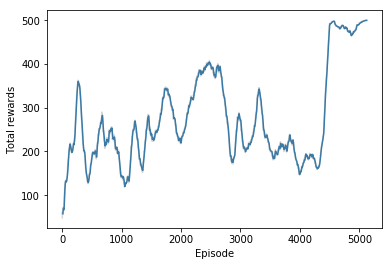

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

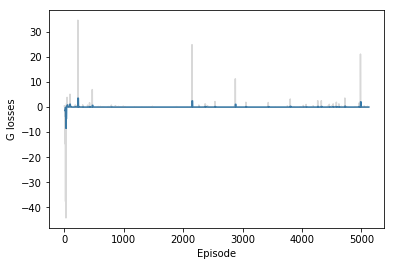

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

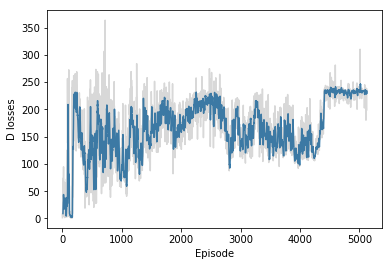

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

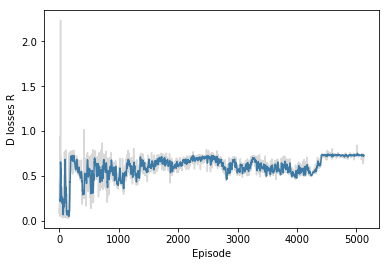

In [58]:
eps, arr = np.array(d_lossQsigm_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

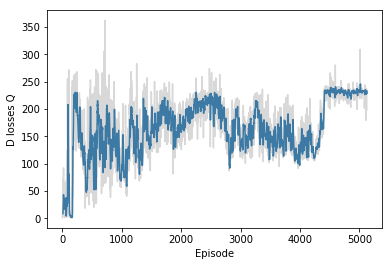

In [59]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            env.render()
            action_logits, g_initial_state, d_initial_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state, 
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
# Closing the env
print('total_reward: {}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.